# Week 10 


<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>



<div style="color:blue;font-style:italic">07.03.2022 - 11.03.2022</div>


<div style="background-color:rgba(256, 76, 76,0.4)",height="200">

<br>

<H4>Abstract</H4>

<br>

</div>

---

A possible approach to a bayesian model for LC-IMS-MS precursor features is a general linear model (GLM). In this week a GLM prototype was introduced into pystoms and a 3D visualization with python library plotly was implemented.

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Introduction</H4>
<br>
</div>

---






---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Methods and Material</H4>
<br>
</div>

---


```python3

```
---

<!-- <div style="background-color:white">

<img src="data/modelGraphviz.svg" >

</div>
<figcaption style="font-weight:bold;font-size:small">
Fig 1: Visualization of artificial Model spanning 10 submodels each receiving an independent dataset of normally distributed data of unknown mean. Visualization was created with python-graphviz <cite data-cite="graphviz"></cite>.
</figcaption> --> 

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Results</H4>
<br>
</div>

---


In [1]:
from pyproteolizard.data import PyTimsDataHandle
from pystoms.feature_loader_dda import FeatureLoaderDDA
from pystoms.models_glm import ModelGLM3D
import aesara
import pymc as pm
import numpy as np
import plotly.io as pio
import arviz as az



In [2]:
#pio.renderers.default = "sphinx_gallery"
# get raw data via proteolizard
data_handle = PyTimsDataHandle('/home/tim/Master/MassSpecDaten/M210115_001_Slot1-1_1_850.d/')
# precursors are listed in precursor table
precursor_table = data_handle.get_selected_precursors()



In [3]:
precursor_table[precursor_table.Id==419]

Id  LargestPeakMz   AverageMz  MonoisotopicMz  Charge  ScanNumber  \
418  419     832.780973  832.780973             NaN     NaN  433.679872   

     Intensity  Parent  
418     2682.0     371

In [4]:
%load_ext autoreload
%autoreload 2

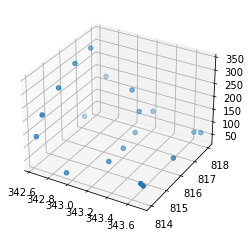

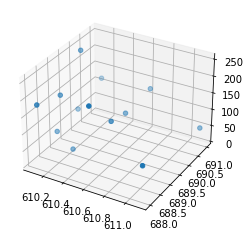

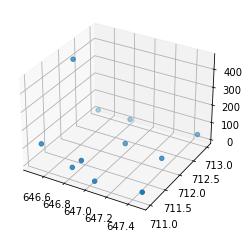

In [5]:
# ectract some features with random ids
features = [200,20,2011,2016,506,302,120]

feature_data = []
charges = []

for feature_id in features:
    feature = FeatureLoaderDDA(data_handle,feature_id)
    # estimate feature hull boundaries with averagine model for isotopic pattern and gaussian model for IMS
    data_tmp = feature.load_hull_data_3d(ims_model="gaussian",plot_feature=True)
    feature_data.append(data_tmp)
    charges.append(feature.charge)
    



In [12]:
# first feature data is needed to declare the model
 
s = feature_data[0]["Scan"].values
m = feature_data[0]["Mz"].values
# intensities must be floats, otherise observed data is not stored
# in inference data due to pymc bug 
# https://github.com/pymc-devs/pymc/issues/5586
i = feature_data[0]["Intensity"].values.astype("float")
z = charges[0]
ims_mu = np.average(s,weights=i)
ims_sigma = np.max(s)-np.min(s)
mz_mu = np.average(m,weights=i)
mz_sigma = 10
alpha_lam = 1/np.max(i)
myModel = ModelGLM3D(s.size,6,z,i,s,m,ims_mu,ims_sigma,mz_mu,mz_sigma,alpha_lam,"",None)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/home/tim/Master/prototyping/repos/pymc/pymc/aesaraf.py:1005: UserWarning:

The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [i_t, i_s, ms_mz, ms_s, alpha, me]
INFO:pymc:NUTS: [i_t, i_s, ms_mz, ms_s, alpha, me]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tu

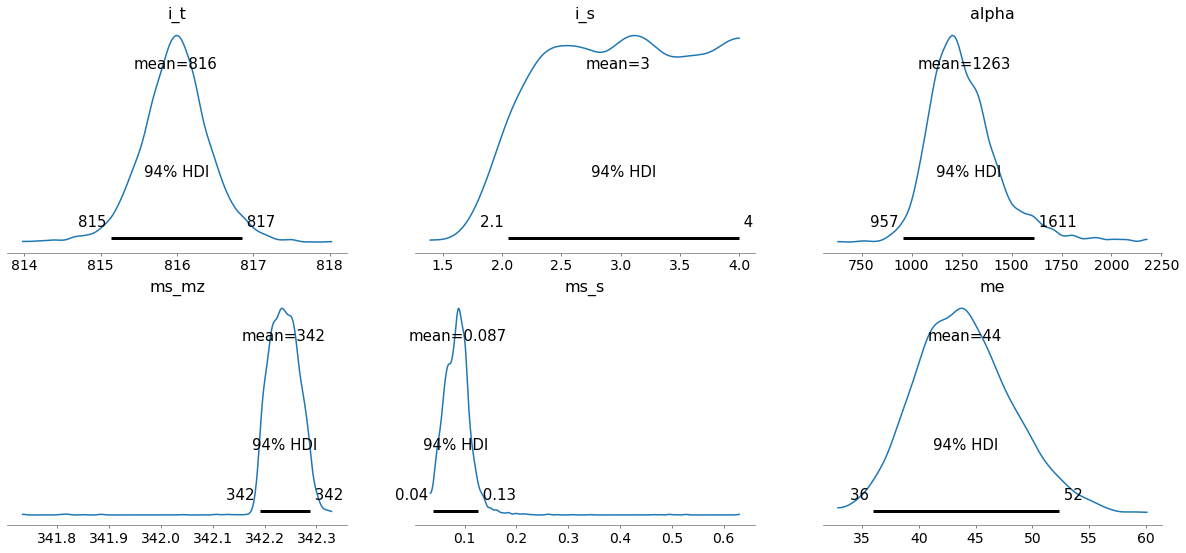

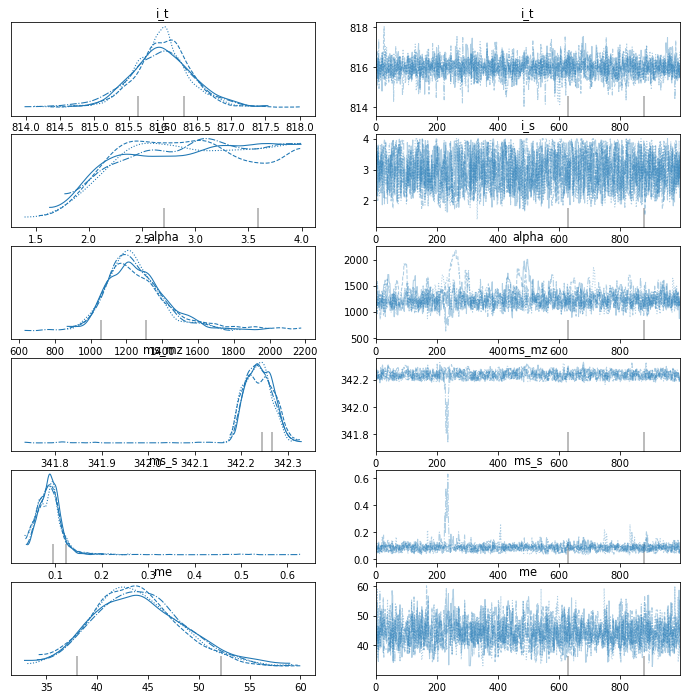

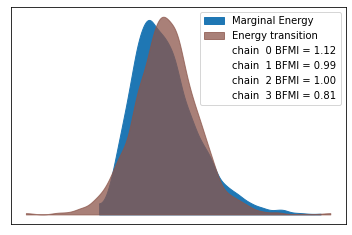

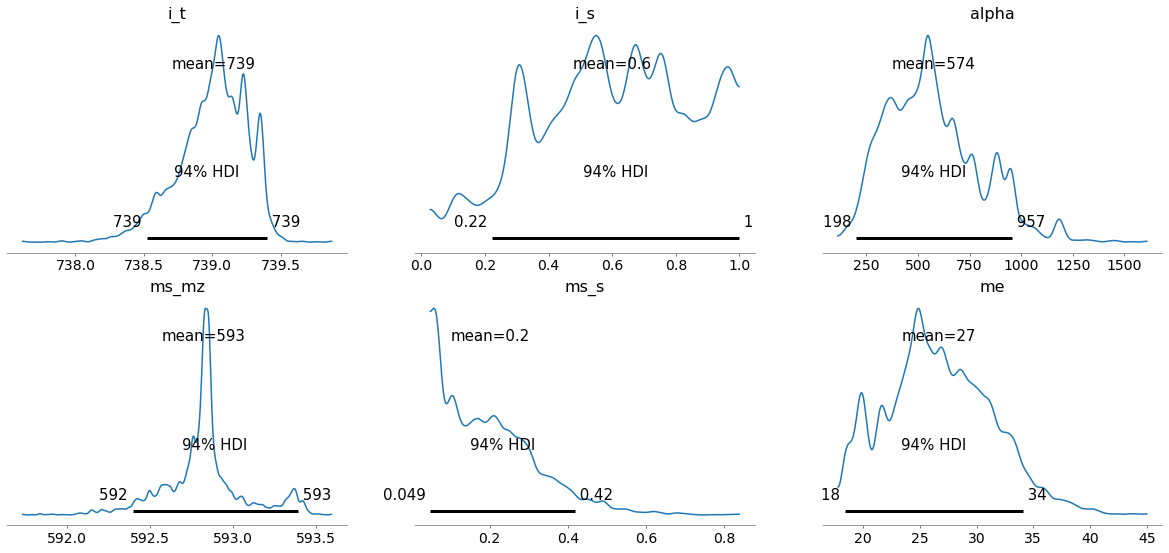

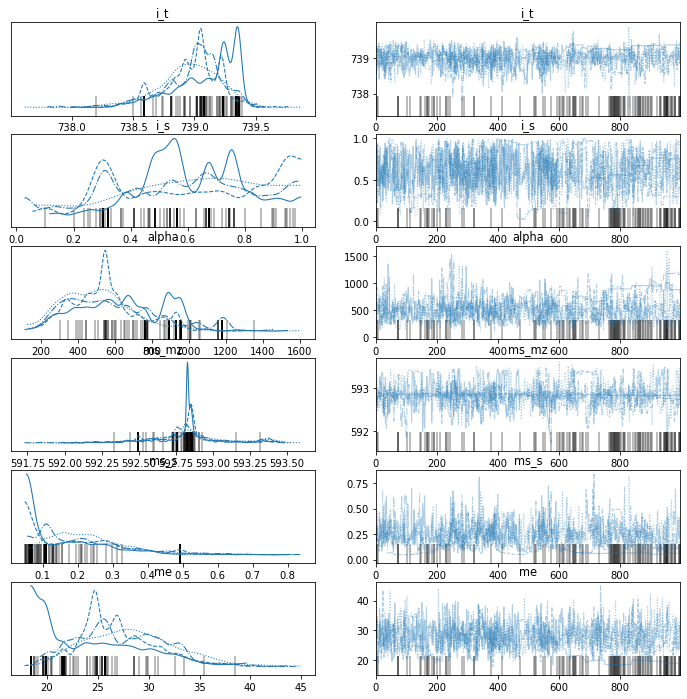

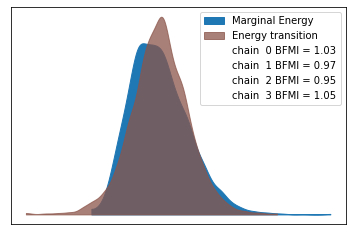

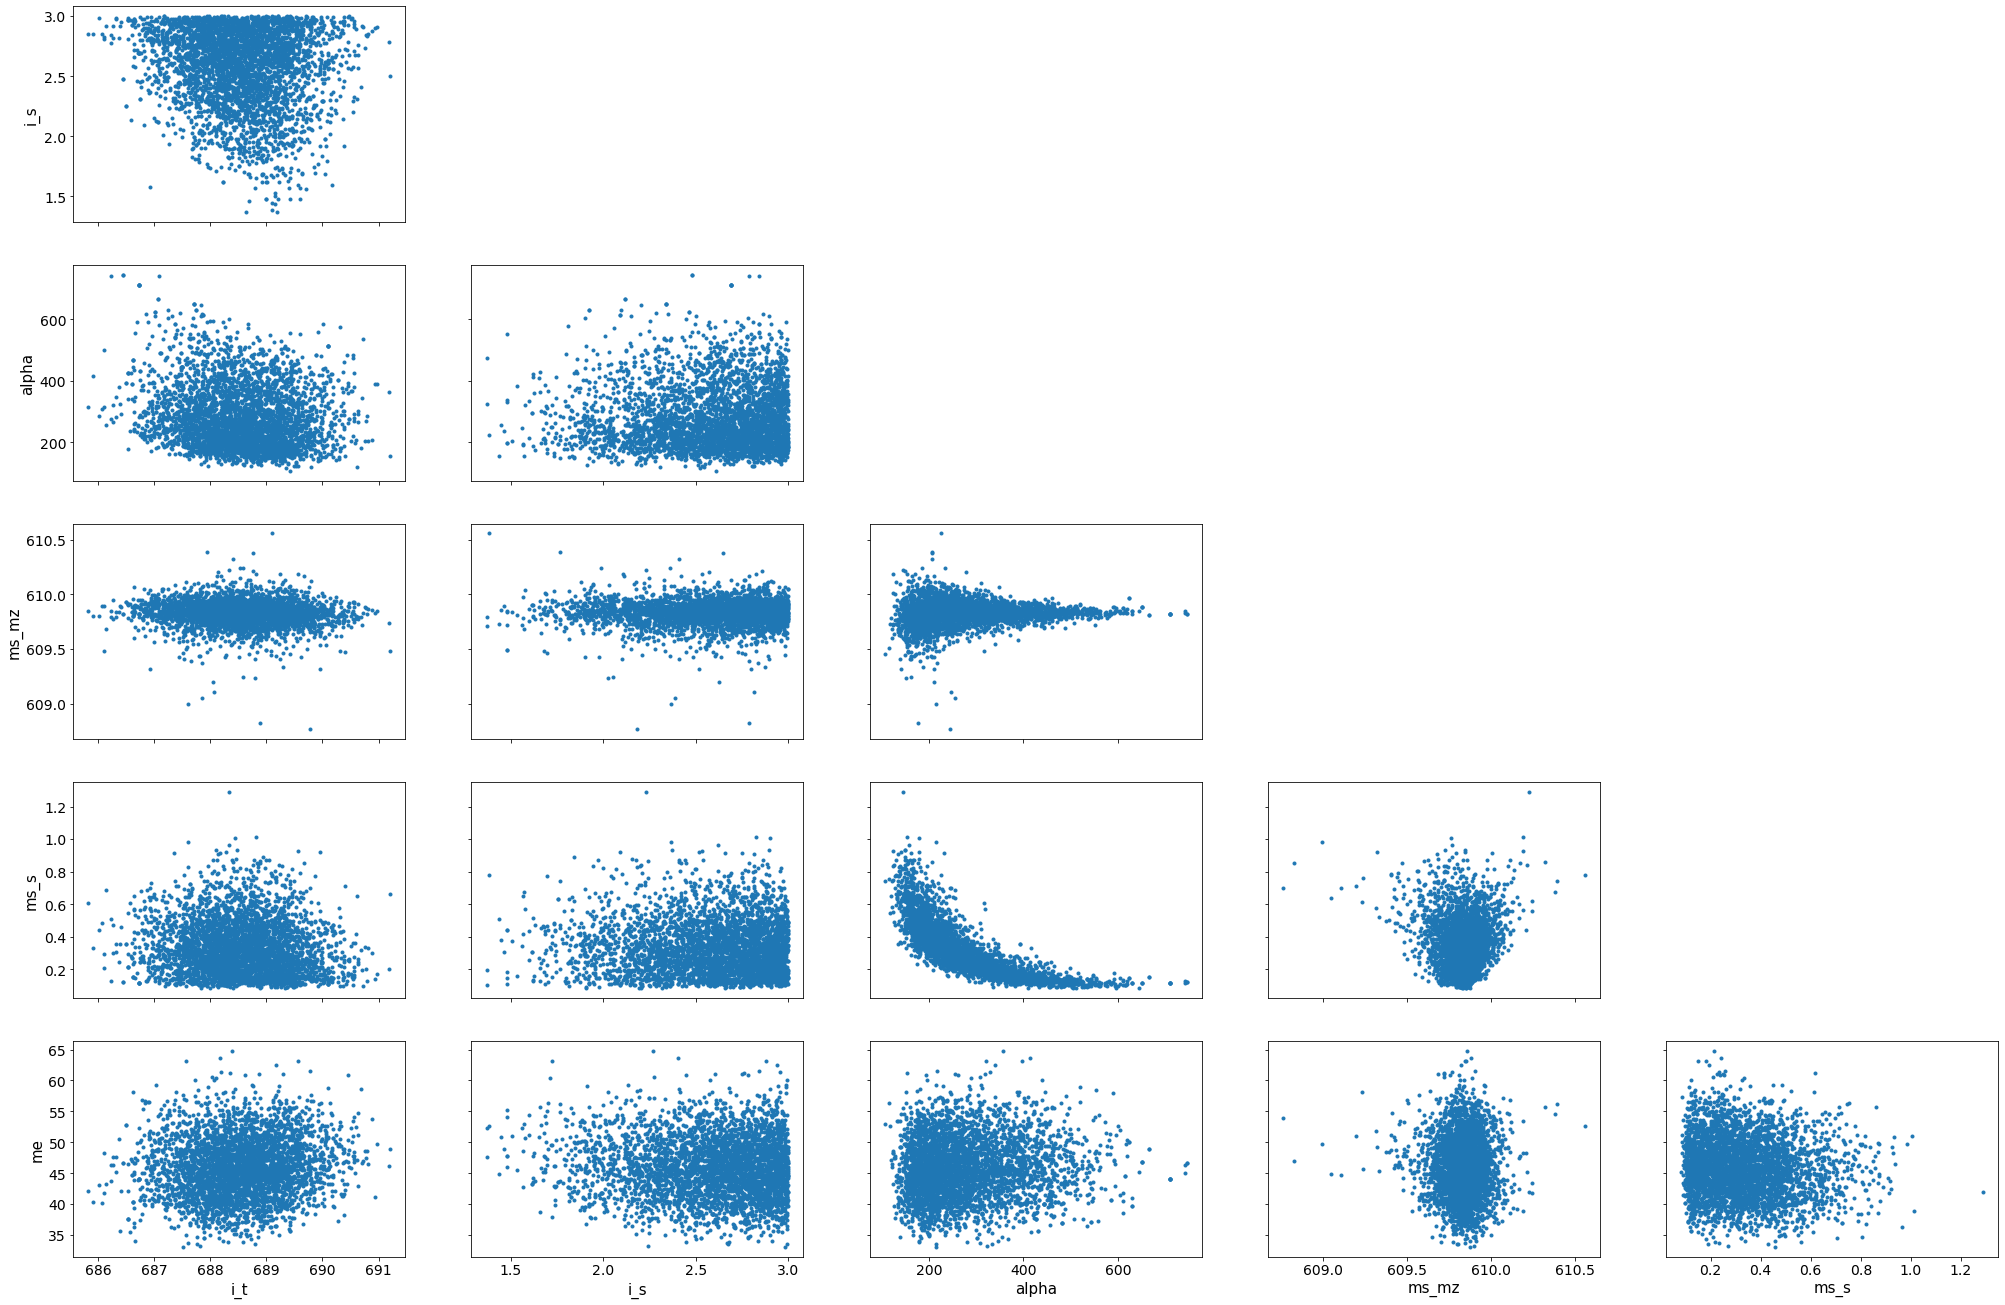

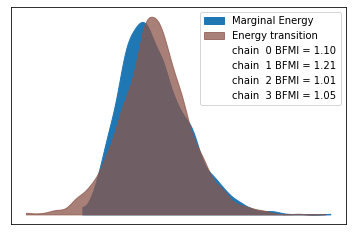

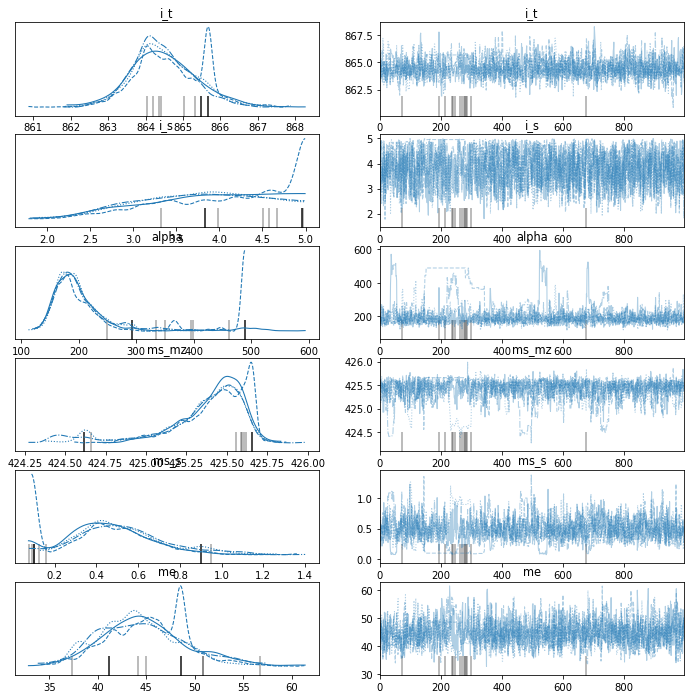

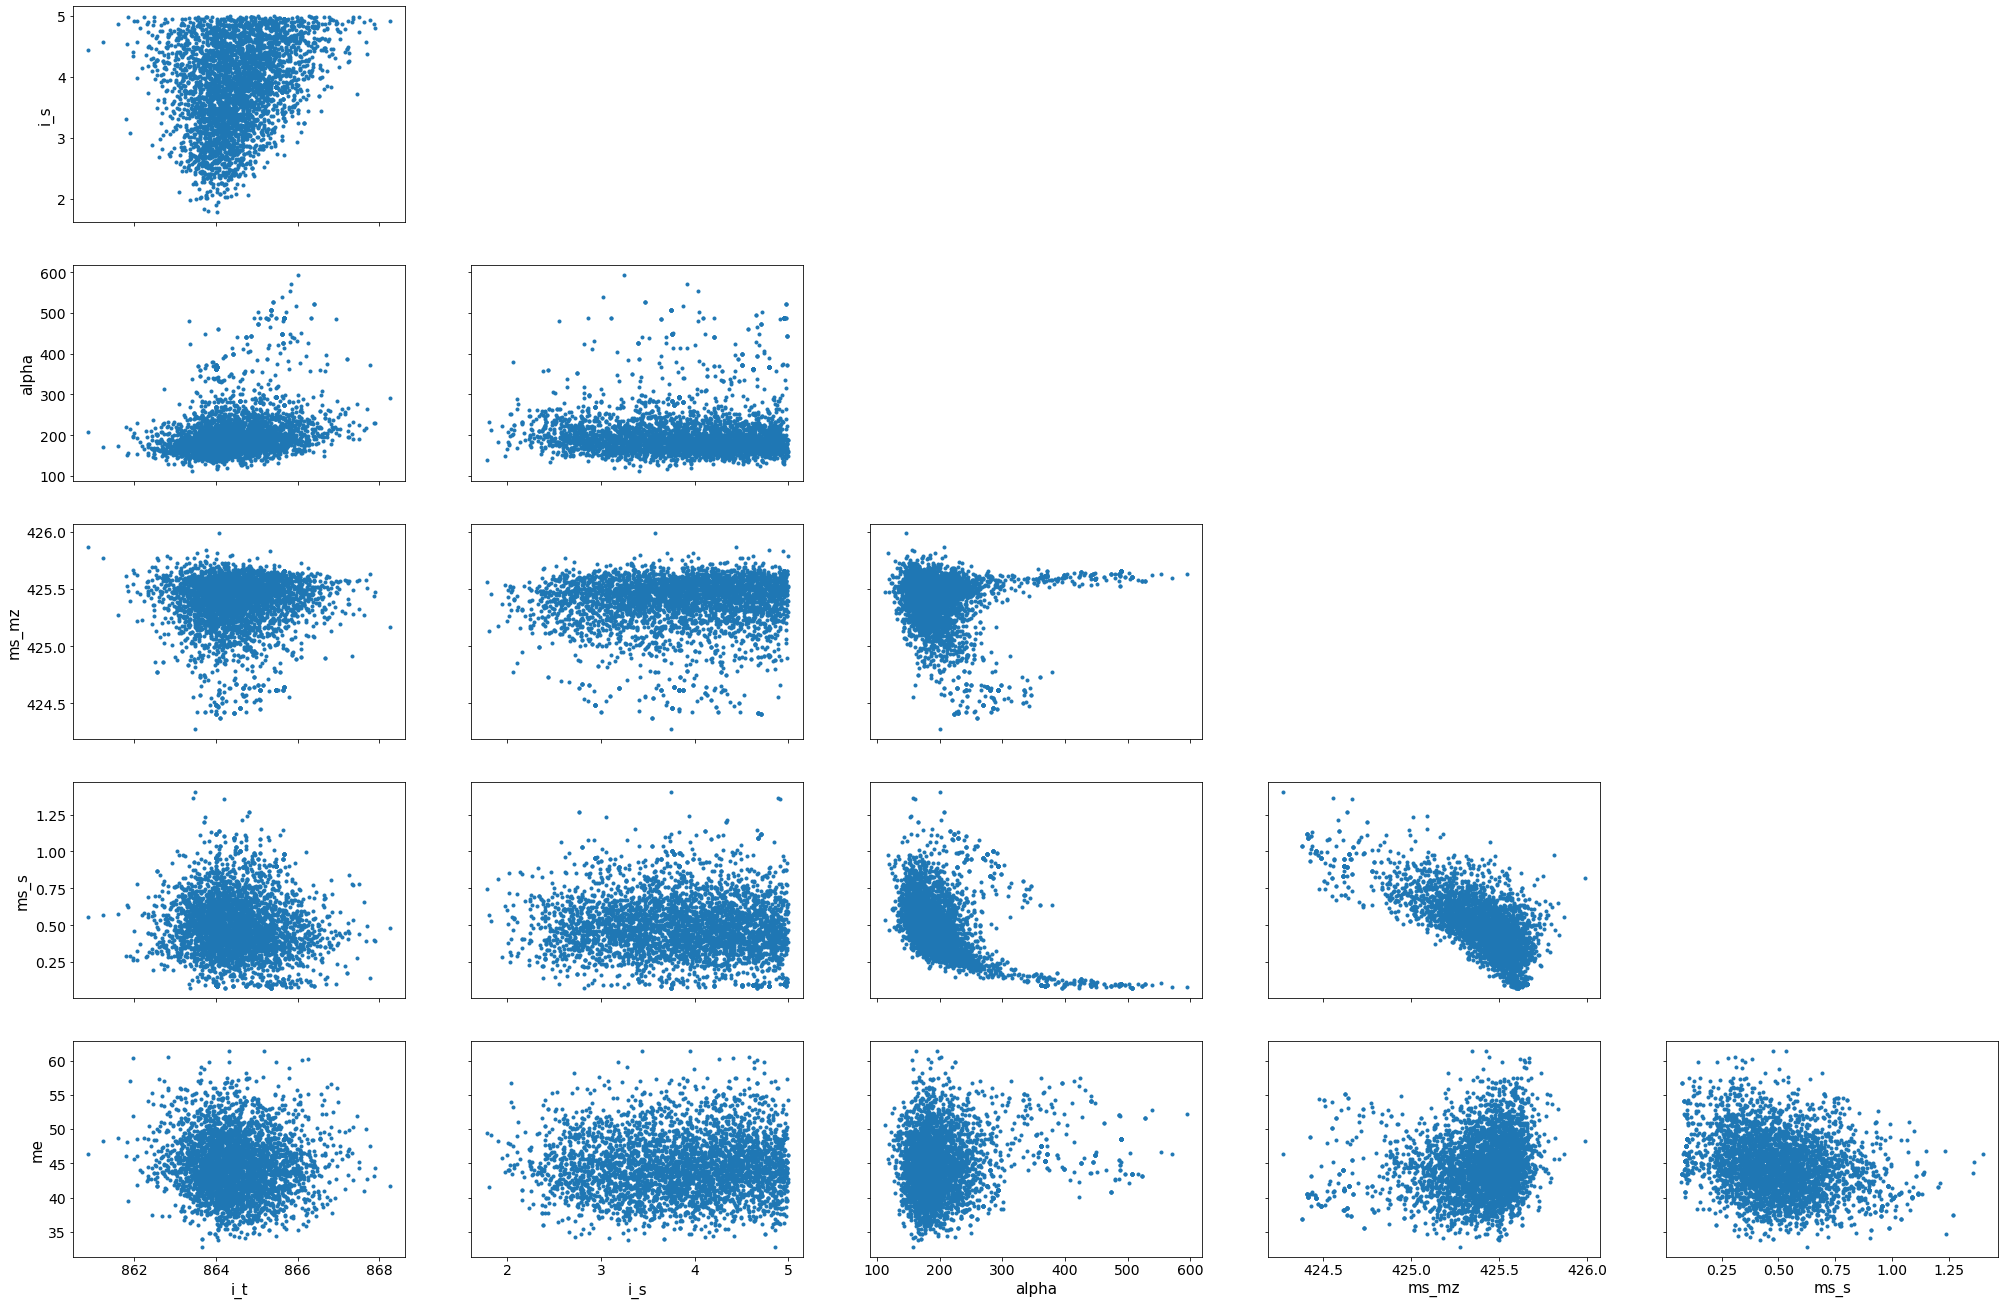

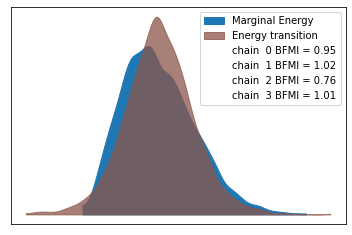

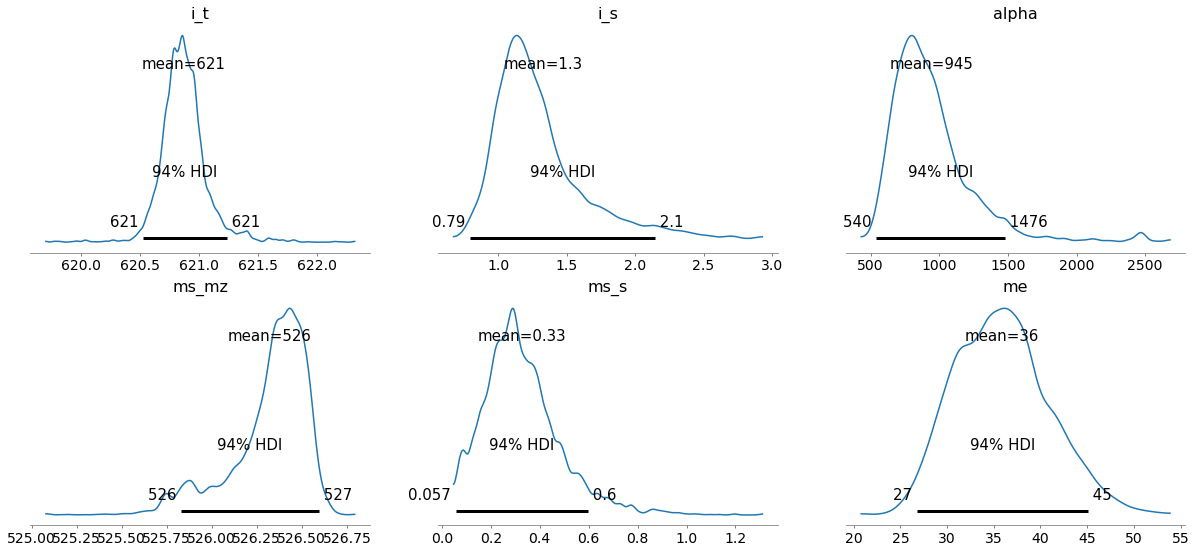

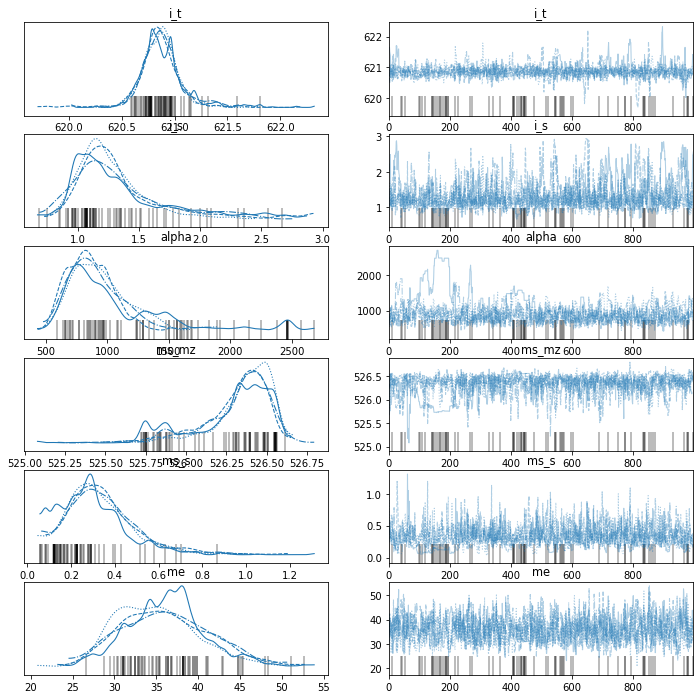

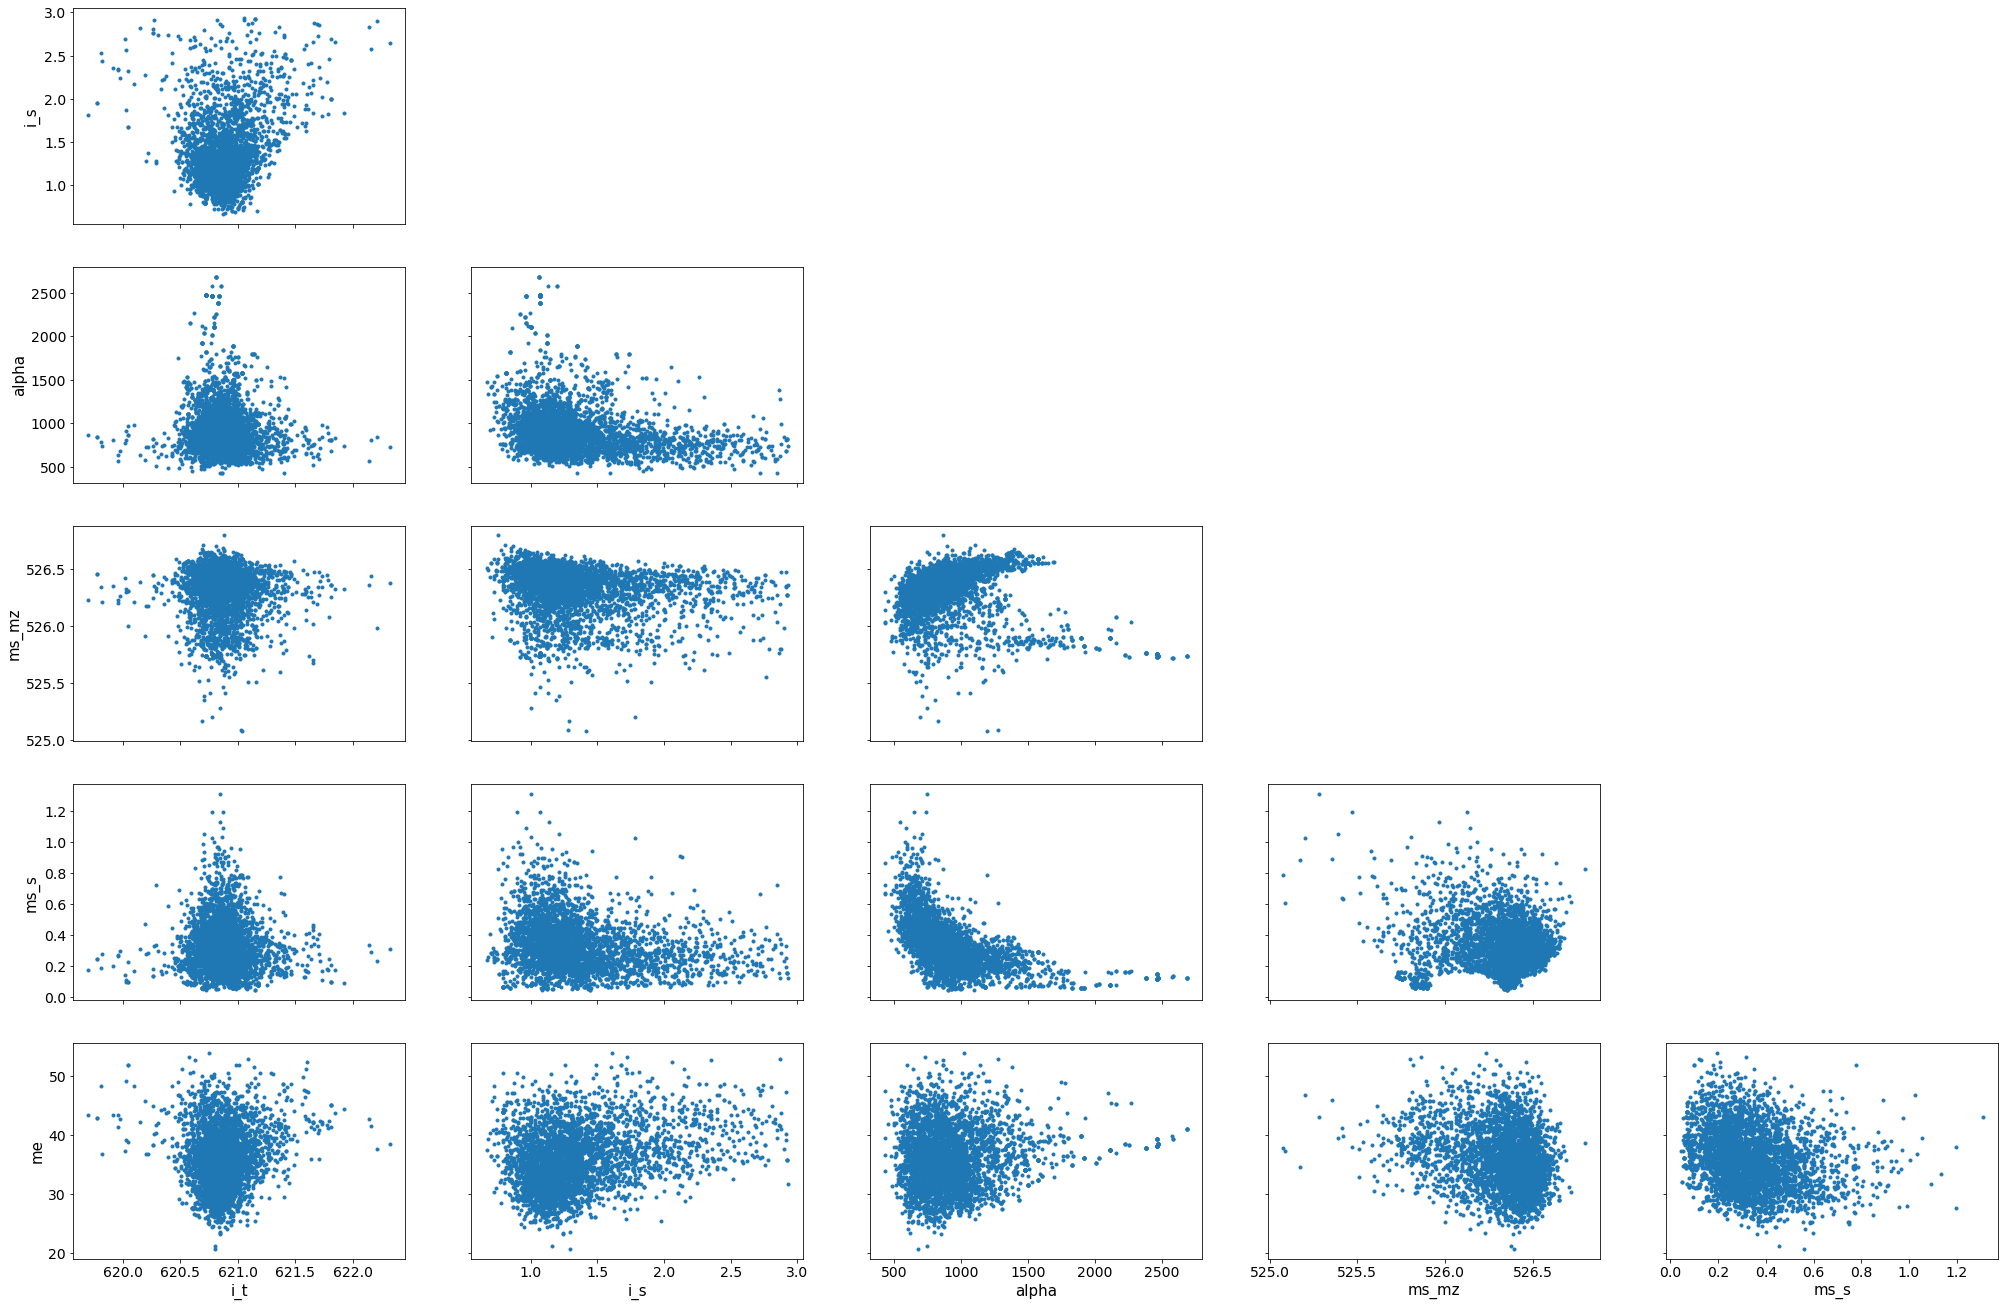

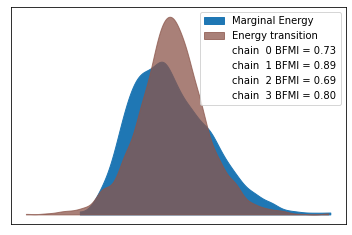

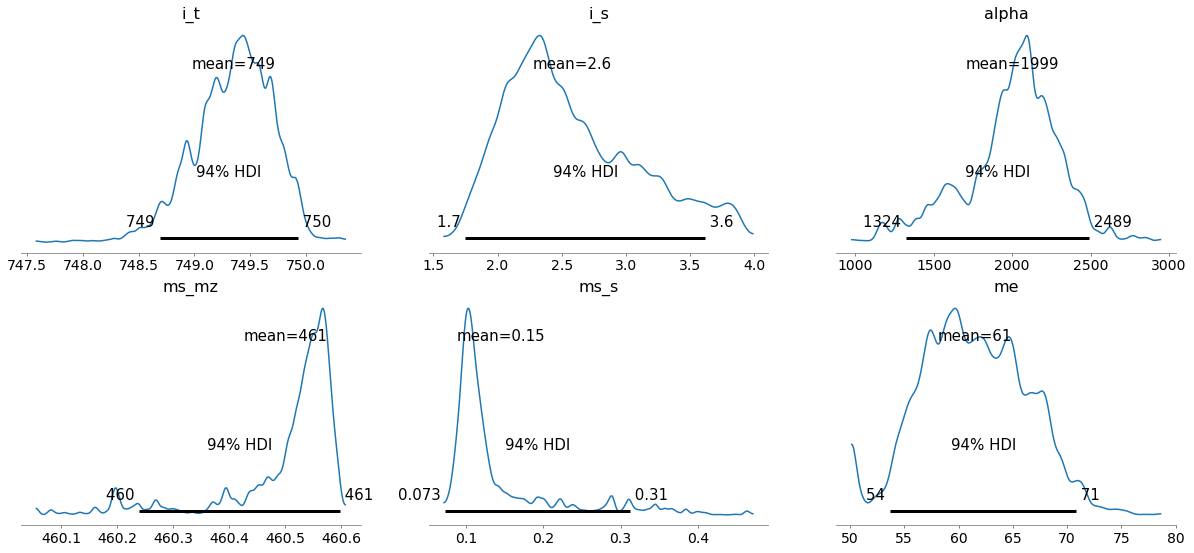

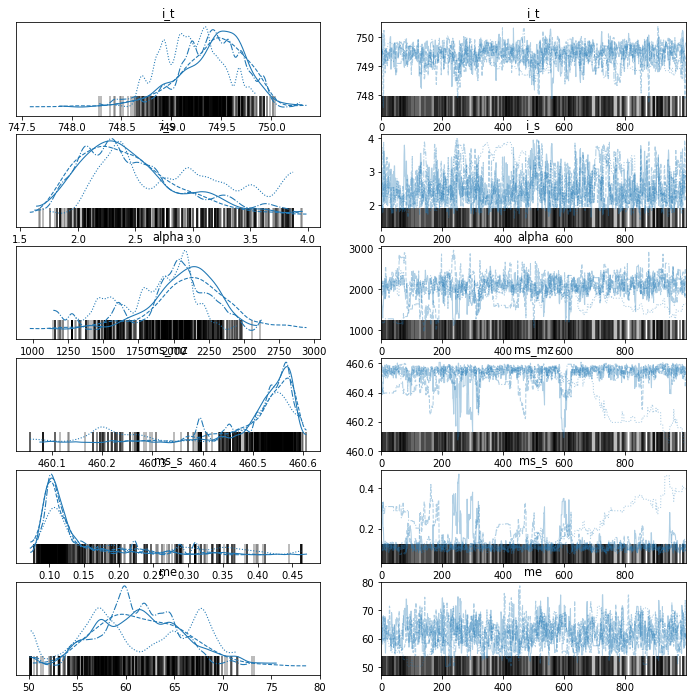

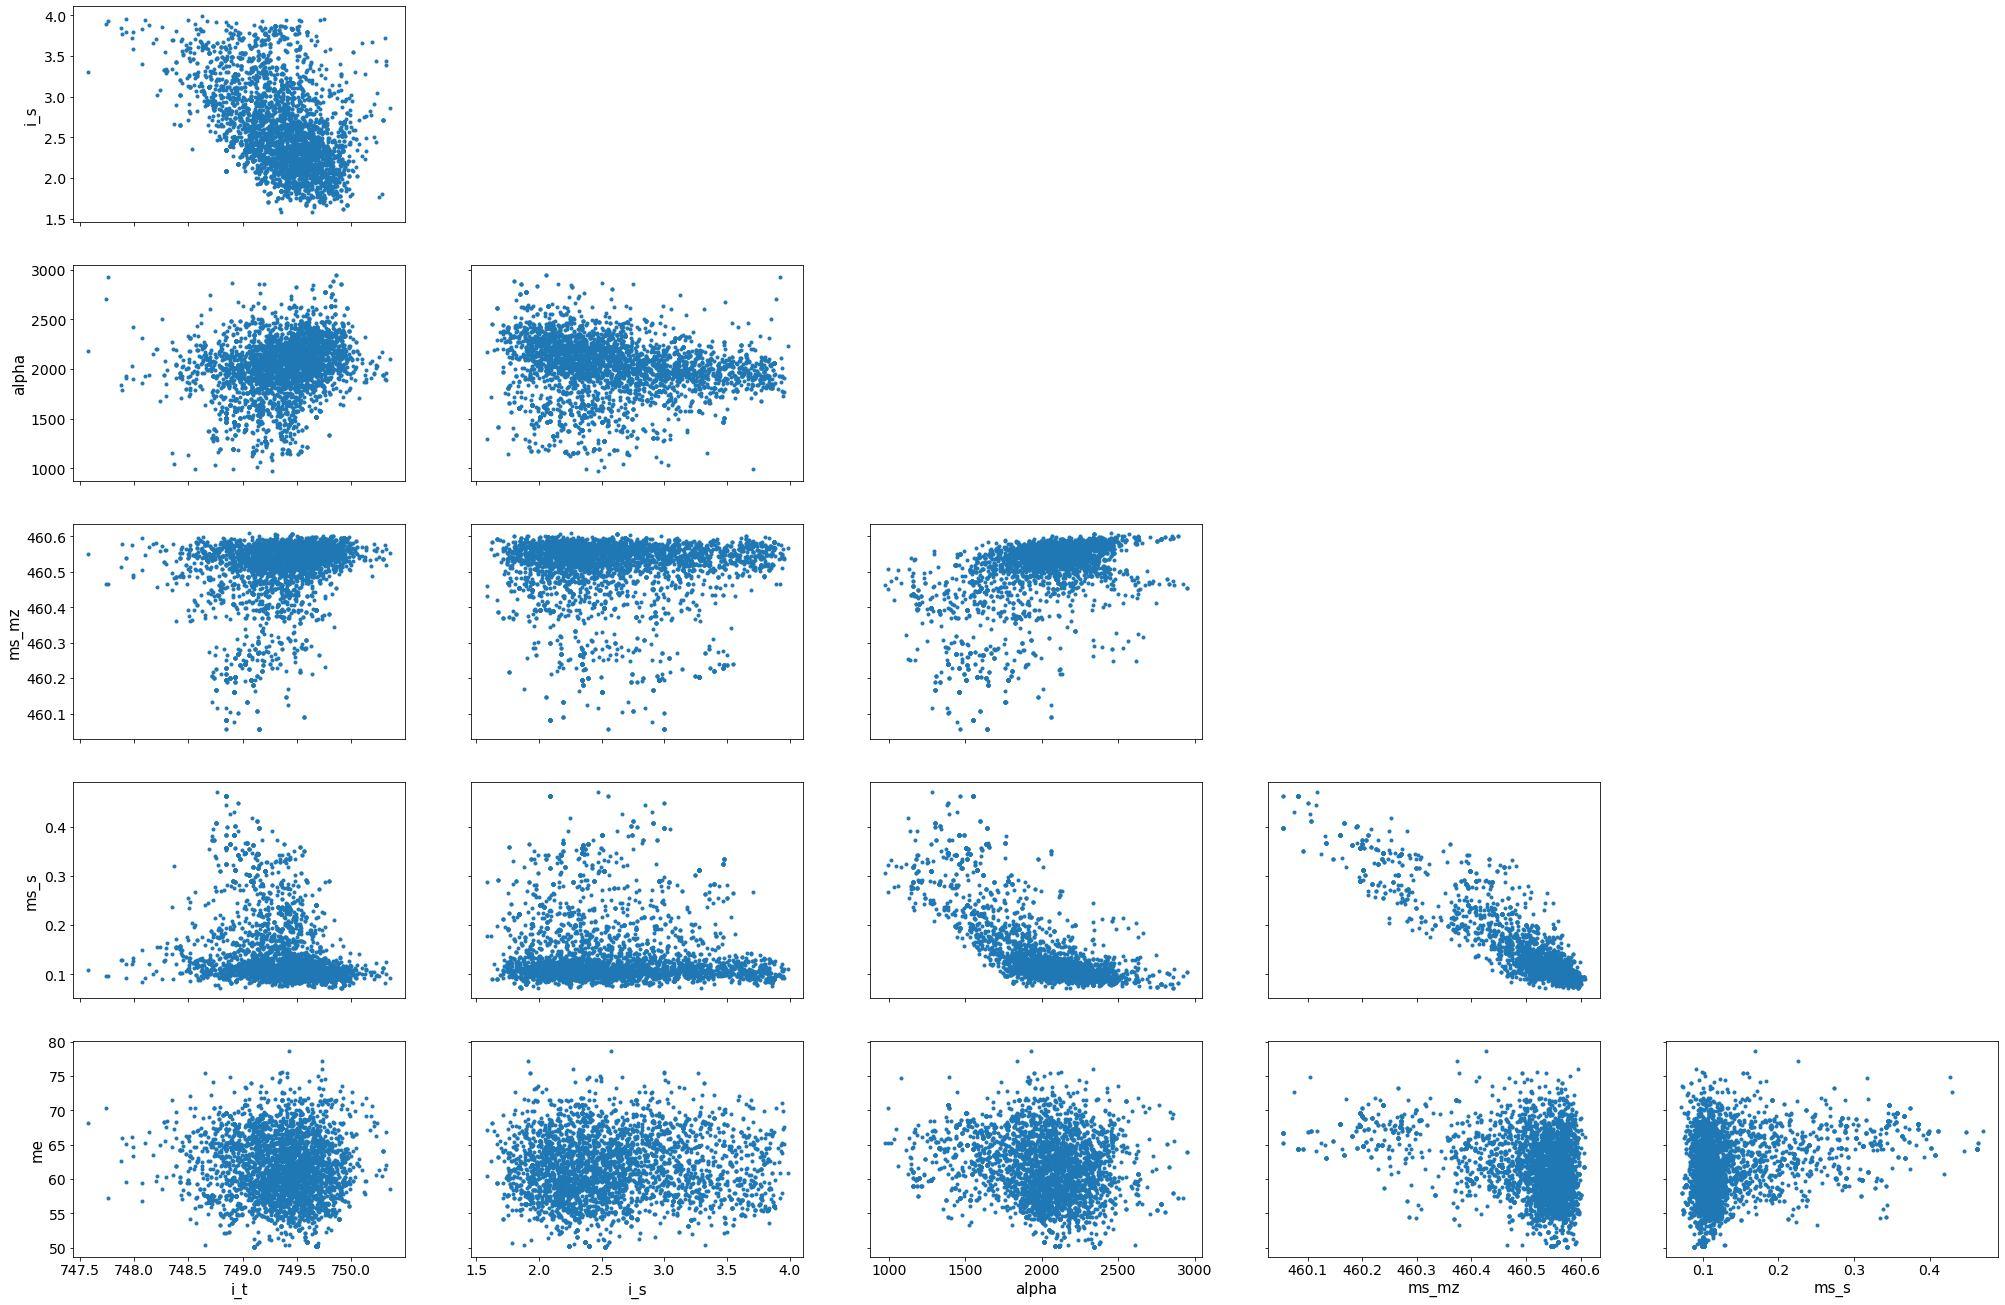

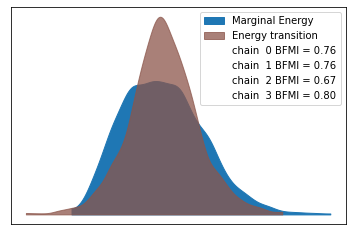

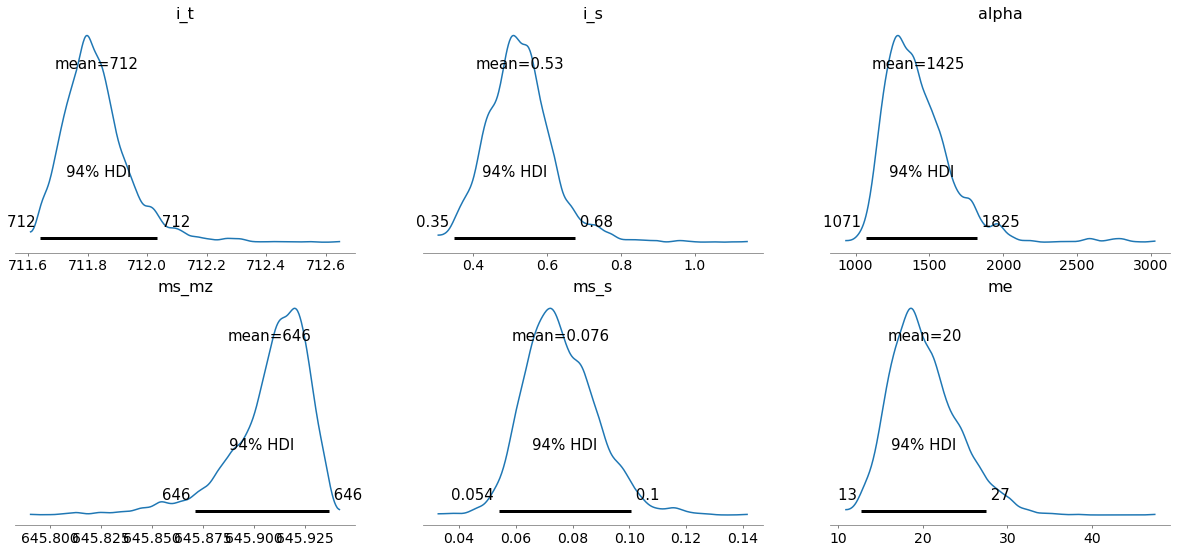

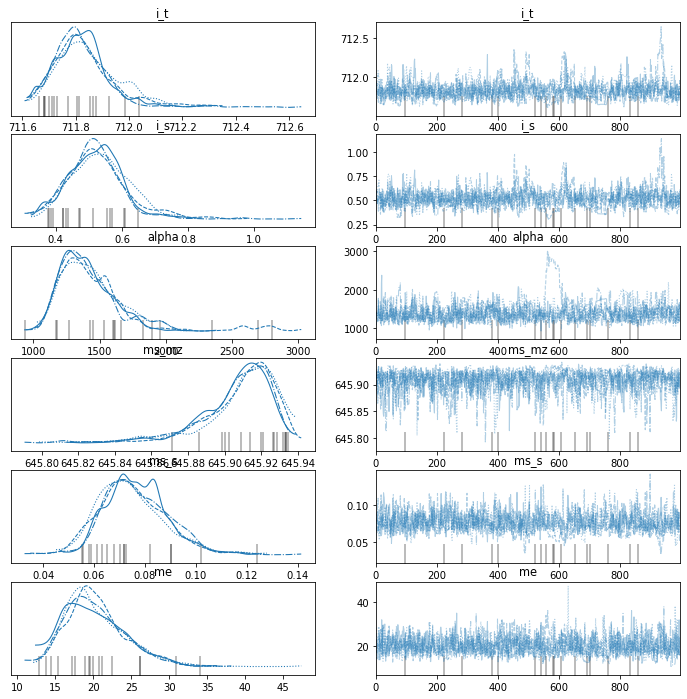

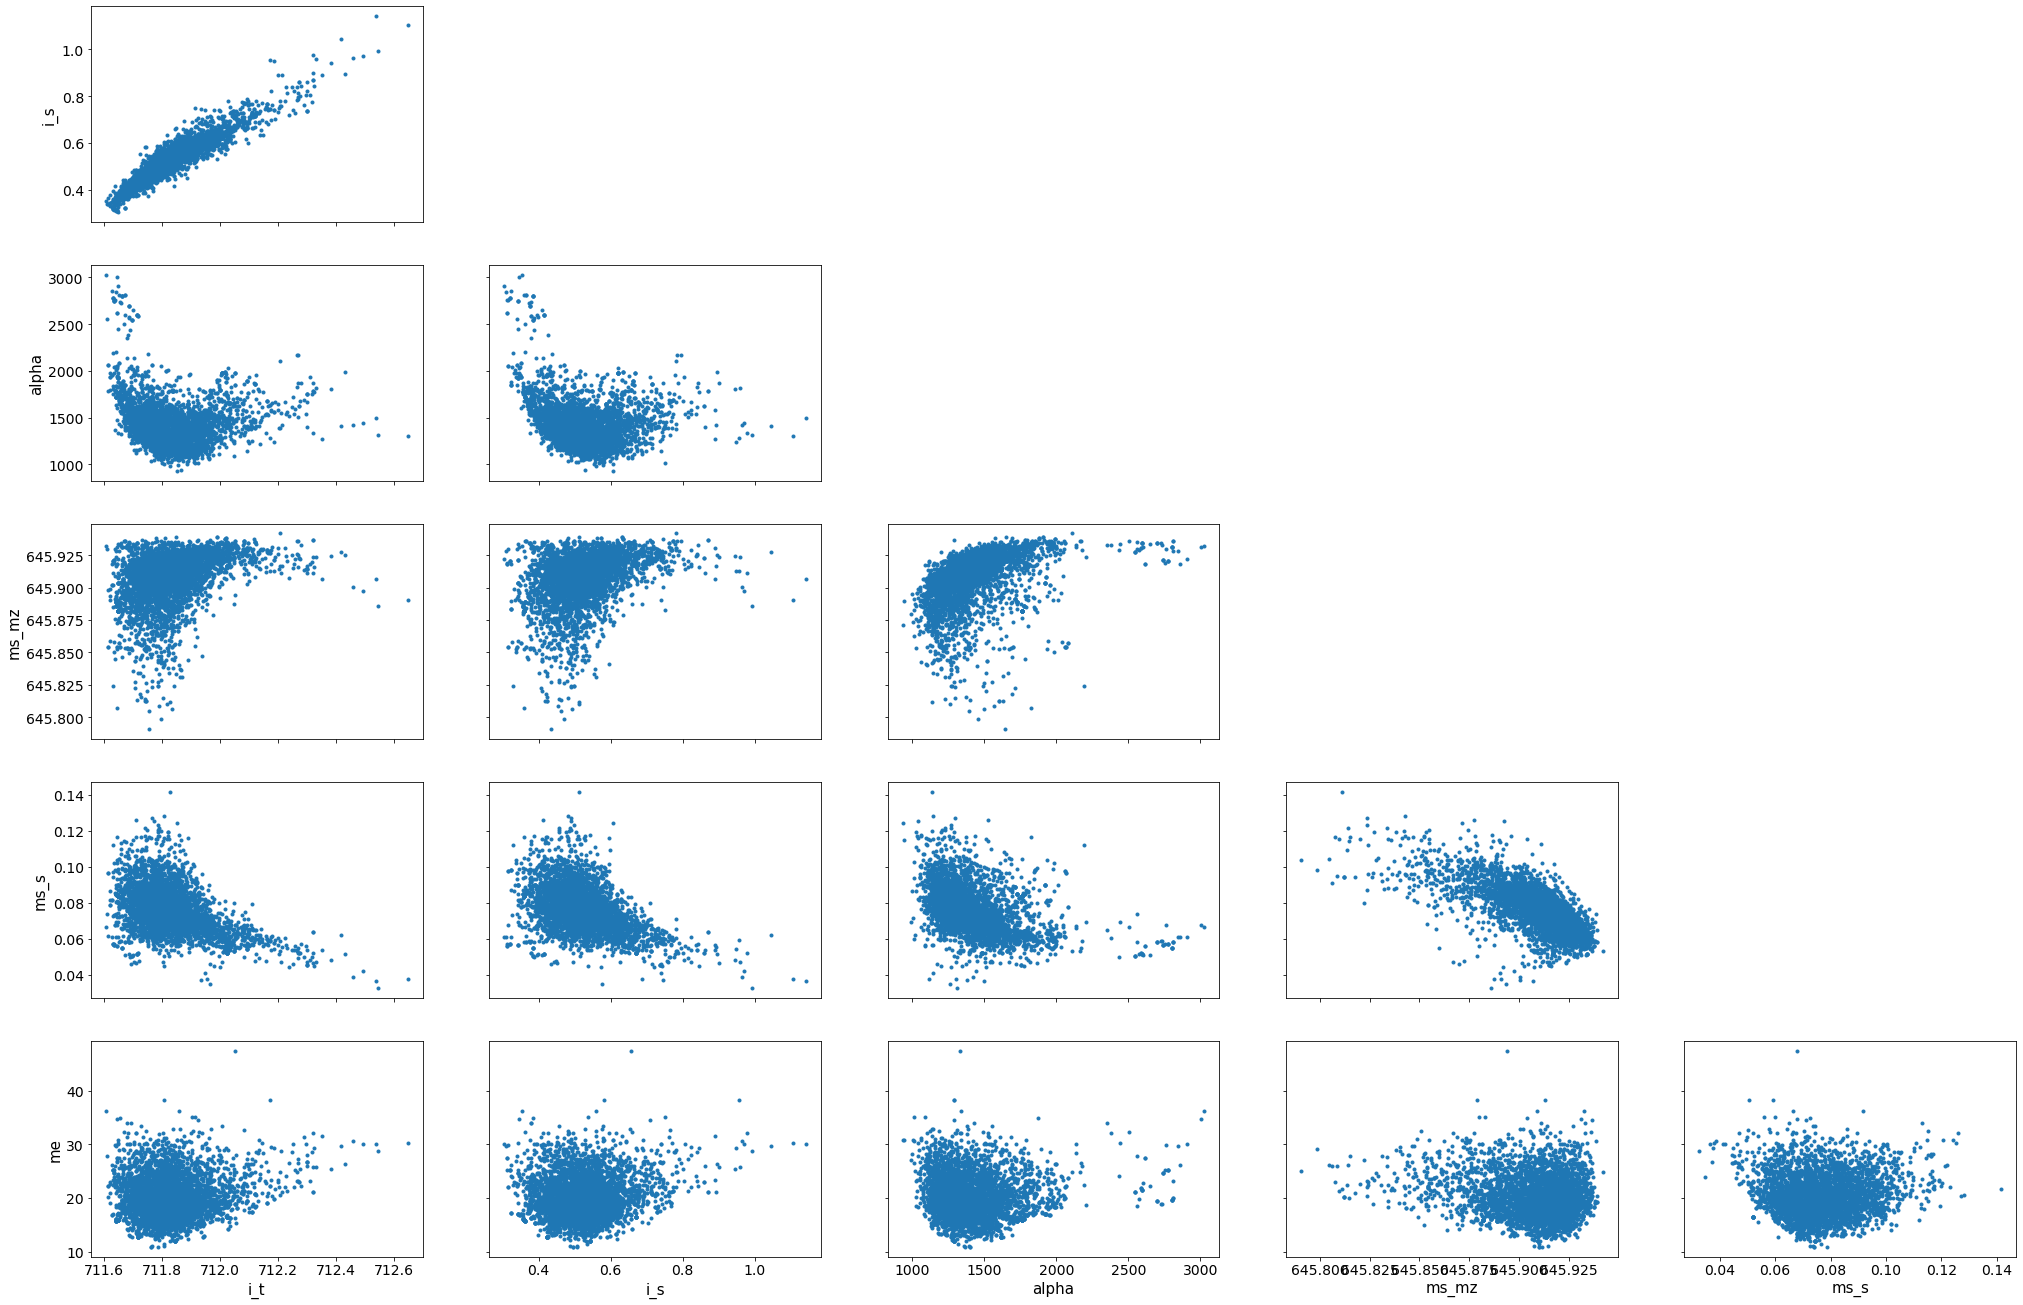

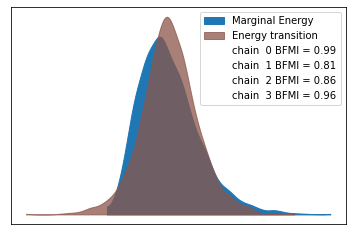

In [13]:
traces = []
for id,z,feature in zip(features,charges,feature_data):
  scans = feature["Scan"].values
  mzs = feature["Mz"].values
  intensities = feature["Intensity"].values
  peak_num = 6
  ims_mu = np.average(scans,weights=intensities)
  ims_sigma = np.max(scans)-np.min(scans)
  mz_mu = np.average(mzs,weights=intensities)
  mz_sigma = 10
  alpha_lam = 1/np.max(intensities)
  with myModel as model:
    # set data with current feature data
    pm.set_data({"charge":z,
                 "scan":scans,
                 "intensity":intensities.astype("float"),
                 "mz":np.tile(mzs,(peak_num,1)).T,
                 "peak_num":peak_num,
                 "peaks":np.tile(np.arange(peak_num),(scans.size,1)),
                 "ims_mu":ims_mu,
                 "ims_sigma":ims_sigma,
                 "mz_mu":mz_mu,
                 "mz_sigma":mz_sigma,
                 "alpha_lam":alpha_lam,
    })
    # evalaution is driver method for pm.sample and plotting,
    # if resample not true, model would not sample if it was 
    # already fitted
    #
    traces.append(model.evaluation(True,True,True,True,["posterior_pred_in","posterior_pred_out","prior_pred_in","prior_pred_out"],progressbar=False,write_to_file=True,path=f"{id}/"))
    model.arviz_plots(path=f"{id}")

In [ ]:
ModelGLM3D()

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Conclusion and Outlook</H4>
<br>
</div>


---



---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>References</H4>
<br>
</div>


---

In [ ]:
.. bibliography:: references10.bib
    :style:

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>To Do</H4>
<br>
</div>


---

Next Steps:

1. Parallelized GLM model
2. Model Evaluation for GLM in pystoms
3. Feature Manager -> handling many features at once
4. Test Model on GPU

5. CPU and GPU breakdown for bigger models in pymc4







---